# ML in Cybersecurity: Project II

## Team
  * **Team name**:  *fill this in*
  * **Members**:  *fill this in. format: name1 (email1), name2 (email2), ...*


## Logistics
  * **Due date**: 28th November 2019, 13:59:59 (right before the lecture)
  * Email the completed notebook to: `mlcysec_ws1920_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 14-Nov-2019: Project 2 hand-out
  * **28-Nov-2019** (13:59:59): Email completed notebook
  * 5-Nov-2019: Project 2 discussion and summary
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal will be train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [1]:
import time 
import collections
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path
import itertools 
from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [3]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '2'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`

In [4]:
# Check that you are prepared with the data
! printf '# train examples (Should be 13682) : '; ls data/train | wc -l
! printf '# test  examples (Should be 10000) : '; ls data/test | wc -l

# train examples (Should be 13682) :    13682
# test  examples (Should be 10000) :    10000


Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

In [59]:
#  Custom method

def helper2_read_pickle(file_name):
    with open(file_name, "rb") as input_file:
        data = pickle.load(input_file)
        return data
    
def file_load(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    label = filepath.split('.')[1]
    
    # Read the file 
    with open(filepath, 'r') as file :
        lines = file.read().splitlines()
    if '# process' in lines[0] :
        del lines[0]
    
    
    # Remove the firstline start with "# process"
    
    # Convert text file to list , content of list is the lines of the textfile.
    
    
    
    return list(set(lines))


def handler(function, data_path, files, workers=6):
    
    with Pool(workers) as pool:
        #pool.map(cycle, offsets)
        r = pool.map(function,[os.path.join(data_path,file) for file in files])
    return r

def handler2(function, files, workers=6):
    
    with Pool(workers) as pool:
        #pool.map(cycle, offsets)
        r = pool.map(function,files)
    return r

def load_data_count(data_path, nworkers=10):
    '''Returns each data sample as a tuple (x, y), x = sequence of strings (i.e., syscalls), y = malware program class'''
    raw_data_samples = []
    #
    #
    # ------- Your Code -------
    #
    #
    raw_data_samples = []
    file_addresses = []
    files = os.listdir(data_path)
    print('Total file is: ', len(files) )
    raw_data_samples = handler(file_load, data_path, files,workers=8)
    return raw_data_samples

    

In [6]:
#list_of_voc = load_data_count(Path('./data/train'), nworkers=6)

# 1. Vectorize Data

In [7]:
def file_load_kernel(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    label = filepath.split('.')[1]
    
    # Read the file 
    with open(filepath, 'r') as file :
        lines = file.read().splitlines()
    if '# process' in lines[0] :
        del lines[0]
    
    
    # Remove the firstline start with "# process"
    
    # Convert text file to list , content of list is the lines of the textfile.
    
    
    
    return lines, label


def load_data(data_path, nworkers=6):
    '''Returns each data sample as a tuple (x, y), x = sequence of strings (i.e., syscalls), y = malware program class'''
    raw_data_samples = []
    #
    #
    # ------- Your Code -------
    #
    #
    raw_data_samples = []
    file_addresses = []
    files = os.listdir(data_path)
    print('Total file is: ', len(files) )
    raw_data_samples = handler(file_load_kernel, data_path, files,workers=6)
    return raw_data_samples

## 1.a. Load Raw Data

In [40]:
print('=> Loading training data ... ')
train_raw_samples = load_data(Path('./data/train'))

# 4 min


=> Loading training data ... 
Total file is:  13682


In [ ]:
'''print(len(train_raw_samples))
out_path = "train_raw_samples_full.pickle"
with open(out_path, 'wb') as wf:
    pickle.dump(train_raw_samples, wf)'''

In [51]:
project_mode = 'debug'    # trainval, traintest, debug
np.random.seed(123)          # To perform the same split across multiple runs

if project_mode == 'trainval':
    # Train = train subset; Test (i.e., validation) = train subset
    val_frac = 0.25
    np.random.shuffle(train_raw_samples)
    split_idx = int(len(train_raw_samples) * val_frac)
    test_raw_samples, train_raw_samples = train_raw_samples[:split_idx], train_raw_samples[split_idx:]
elif project_mode == 'traintest':
    # Train = full train set; Test = full test set
    test_raw_samples = load_data(Path('./data/test'))
elif project_mode == 'debug':
    # Train = train micro-subset; Test (i.e., validation) = train micro-subset
    np.random.shuffle(train_raw_samples)
    train_raw_samples, test_raw_samples = train_raw_samples[:500], train_raw_samples[500:1000]
else:
    raise ValueError('Unrecognized mode')
    
print('=> # Train samples = ', len(train_raw_samples))
print('=> # Test  samples = ', len(test_raw_samples))
#2

=> # Train samples =  500
=> # Test  samples =  500


## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

In [52]:
# Feel free to edit anything in this block

def get_key_idx_map(counter, vocab_size, ukn_token='_ukn_'):
    # counter is a mapping: token -> count
    # build vectorizer using vocab_size most common elements
    counter_unk = counter
    frequency_table = {key: counter[key] for key in counter if counter[key]>10 }
    
   
    counter_unk.update({ukn_token:(vocab_size - len(counter))})
    key_to_idx, idx_to_key = dict(), dict()
    for i in range(len(counter_unk)):
        idx_to_key.update({i:list(counter_unk.keys())[i]})
        key_to_idx.update({list(counter_unk.keys())[i]:i})
    return key_to_idx, idx_to_key

def helper1_count_frequncy(training_raw_data):
    l = list(map(lambda x: x[0], training_raw_data))
    i = list(itertools.chain(*l))
   
    
    return collections.Counter(i)



def get_class_key_index_map(class_counter):
  #  { 'Agent':0, 'Allaple':1, 'AutoIt': 2, 'Basun':3, 'NothingFound':4, 'Patched': 5, 'Swizzor':6, 'Texel':7, 'VB': 8, 'Virut':9 }
    class_index = class_counter
    index_class = dict((v,k) for k,v in class_index.items())
    nb_classes = len(class_counter)
    targets = np.array([class_counter.keys()]).reshape(-1)
    one_hot_targets = np.eye(nb_classes).tolist()
    class_index = dict(zip([*class_index], one_hot_targets))
    return class_index, index_class




In [62]:
def store_token_index(token_counter):

    token_to_idx, idx_to_token = get_key_idx_map(token_counter, 60000)

    # Save vocab to file out_path = 'application_vocab_full{}.pkl'.format(MAX_VOCAB_SIZE^
    #out_path = 'application_vocab_full{}.pkl'.format(MAX_VOCAB_SIZE)
    
    return [token_to_idx, idx_to_token]

In [63]:
train_raw_samples_list =  [train_raw_samples[x:x+1000] for x in range(0, len(train_raw_samples), 1000)]
print('done chopping')
token_counter_list = handler2(helper1_count_frequncy, train_raw_samples,workers=6)
print('done_calculating counter list')
token_idx_map_list_of_dict = handler2(store_token_index,token_counter_list, workers=6)
print('done calculating sub (token_to_idx, idx_to_token) maping ')


#[[{},{}],[{},{}]]

done chopping
done_calculating counter list
done calculating sub (token_to_idx, idx_to_token) maping 


In [65]:
# Feel free to edit anything in this block



#token_counter = #helper1_count_frequncy(train_raw_samples)



token_to_idx, idx_to_token = dict(), dict()

for item in token_idx_map_list_of_dict:
    token_to_idx.update(item[0])
    idx_to_token.update(item[1])
    
#get_key_idx_map(token_counter, MAX_VOCAB_SIZE)

# Save vocab to file
out_path = 'application_vocab_full{}.pkl'.format(MAX_VOCAB_SIZE)
with open(out_path, 'wb') as wf:
    dct = {'token_to_idx': token_to_idx,
          'idx_to_token': idx_to_token}
    pickle.dump(dct, wf)
    
# 4

## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [66]:
#
#
# ------- Your Code -------
#
#
picle_token_index_dict = helper2_read_pickle(out_path)
token_to_idx, idx_to_token = picle_token_index_dict['token_to_idx'], picle_token_index_dict['idx_to_token']



In [67]:
def vectorize_raw_samples(raw_samples, nworkers=10):
    vectorized_samples = []
    #
    #
    # ------- Your Code -------
    #
    #
    classes = { 'Agent':0, 'Allaple':1, 'AutoIt': 2, 'Basun':3, 'NothingFound':4, 'Patched': 5, 'Swizzor':6, 'Texel':7, 'VB': 8, 'Virut':9 }
    class_onehot, index_class = get_class_key_index_map(classes)
    out_path = "application_vocab_1000000.pkl" # Change this line 
    picle_token_index_dict = helper2_read_pickle(out_path)
    token_to_idx, idx_to_token = picle_token_index_dict['token_to_idx'], picle_token_index_dict['idx_to_token']

    #data = load_data(raw_samples, nworkers)
    
    #tokens_list = list(token_to_idx.keys())
    #print(tokens_list)
    
    print(token_to_idx.get('_ukn_'))
    
    for l in raw_samples:
        temp_list = [0 for i in range(len(token_to_idx))]
        
        
        
        
        for i in l[0]:
            # The method is called bag of words
            index = token_to_idx.get(i)#[token_to_idx[i]]
            if index:
                temp_list[index] = temp_list[index] + 1
                #temp_list.append(index)
            else:
                temp_list[token_to_idx.get('_ukn_')] = temp_list[token_to_idx.get('_ukn_')] + 1
                #temp_list.append(token_to_idx.get('_ukn_'))
        if(class_onehot.get(l[1])):
            vectorized_samples.append((temp_list, class_onehot.get(l[1])))
        else:
            vectorized_samples.append((temp_list, class_onehot.get( 'NothingFound'))) 
        #vectorized_samples.append(([token_to_idx.get(i) if token_to_idx.get(i) else token_to_idx.get('_ukn_') for  i in l[0]], l[1]))
    

    return vectorized_samples

In [68]:
print('=> Processing: Train')
train_data = vectorize_raw_samples(train_raw_samples)
print()
print('=> Processing: Test')
test_data = vectorize_raw_samples(test_raw_samples)
# 0.5 min

=> Processing: Train
72153

=> Processing: Test
72153


In [69]:
#
#
# ------- Your Code -------
#
#
# Suggestions: 
#



def max_list_lenght(list_2d):
    max_len = 0
    for i in list_2d:
        if len(i)> max_len:
            max_len = len(i)
    return max_len
        

train_x , train_y = [x for x,_ in train_data],[y for _,y in train_data]
test_x , test_y = [x for x,_ in test_data],[y for _,y in test_data]

max_len = max_list_lenght(train_x)
train_x = [x + [0] * (max_len - len(x)) for x in train_x]
#print(train_x)
train_x = torch.tensor(train_x)


train_y = torch.FloatTensor(train_y)
test_x = [x + [0] * (max_len - len(x)) for x in test_x]
test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y)



#print(train_y)

# Suggestions: 
#
# (a) You can use torch.utils.data.TensorDataset to represent the tensors you created previously
trainset = TensorDataset(train_x, train_y)  
testset = TensorDataset(test_x, test_y)



# (a) You can use torch.utils.data.TensorDataset to represent the tensors you created previously
# trainset = TensorDataset(train_x, train_y)
# testset = TensorDataset(test_x, test_y)
#
# (b) Store your datasets to disk so that you do not need to precompute it every time

# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although I often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [70]:
# Feel free to edit anything in this block

# Feel free to edit anything in this block

def evaluate_preds(y_gt, y_pred):
    y_gt = [np.where(r==1)[0][0] for r in y_gt]
    y_pred = [np.where(r==1)[0][0] for r in y_pred]

    return 0


def another_helper(question):
    return 42


def save_model(model, out_path):
    torch.save(model.state_dict(), out_path)


def save_data(eval_data, out_path):
    with open(out_path, 'wb') as handle:
        pickle.dump(eval_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

## 2.b. Define Model

Describe your model here.

In [71]:
# Feel free to edit anything in this block

class NetDNN(nn.Module):
    def __init__(self, in_dims, h1, h2, out_dims):
        super(NetDNN, self).__init__()
        # Layer definitions
        self.fc1 = nn.Linear(in_dims, 512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,h1)
        self.fc4 = nn.Linear(h1,h2)
        self.fc5 = nn.Linear(h2,out_dims)

    def forward(self, x):
        # Forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x))
        return x

## 2.c. Set Hyperparameters

In [72]:
# Define your hyperparameters here

in_dims = trainset[0][0].shape[0]
print('Input di',in_dims)
h1, h2 = 128, 128
out_dims = 10
print('Output dim', out_dims)

# Optimization
n_epochs = 25
batch_size = 5 # Originally 32
lr = 1e-2
momentum = 0.9

Input di 72154
Output dim 10


## 2.d. Train your Model

In [73]:
# Feel free to edit anything in this block

net = NetDNN(in_dims, h1, h2, out_dims)
net.train()

criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

# Data Loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloader = {'train': trainloader,'val': testloader}

# Etc.

In [74]:
#
#
# ------- Your Code -------
#
# Example:
from livelossplot import PlotLosses

def train_model(model,criterion, optimizer, n_epochs):
    eval_data = {}
    model = model.to(device)
    live_plot = PlotLosses()
    epoch_list = []
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(n_epochs):
        logs = {}
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            if phase == 'val':
                model.eval()

            running_loss = 0.0
            ruuning_corrects = 0


            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs.float())
                labels = labels.to(device=device, dtype=torch.int64)
                loss = criterion(outputs, torch.max(labels, 1)[1])

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()


            _, preds = torch.max(outputs, 1)

            running_loss += loss.detach()* inputs.size(0)
            labels_nonhot =  torch.tensor([np.where(r==1)[0][0] for r in labels.data])

            ruuning_corrects += torch.sum(preds == labels_nonhot)

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = ruuning_corrects.float() / len(dataloader[phase].dataset)
      
            prefix = ''
            if phase == 'val':
                prefix = 'val_'

            logs[prefix + 'log_loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
            
        epoch_list.append(epoch)
        train_loss_list.append(logs['log_loss'])
        test_loss_list.append(logs['val_log_loss'])
        train_acc_list.append(logs['accuracy'])
        test_acc_list.append(logs['val_accuracy'])
        live_plot.update(logs)
        live_plot.draw()
    eval_data['epoch'] = epoch_list
    eval_data['train_loss'] = train_loss_list
    eval_data['test_loss'] = test_loss_list
    eval_data['train_acc'] = train_acc_list
    eval_data['test_acc'] = test_acc_list
    
    return model, eval_data   
    


    



## 2.e. Evaluate model

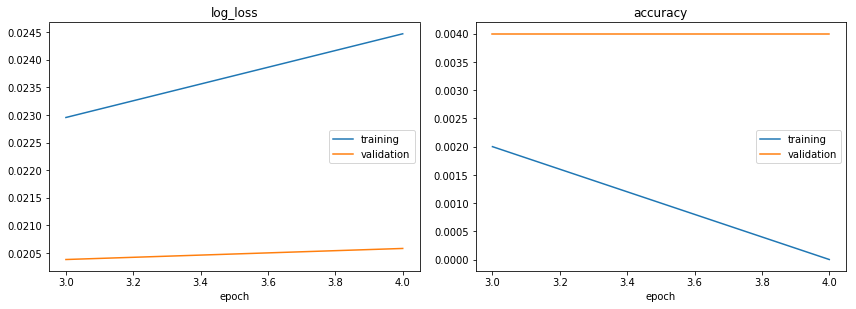

log_loss:
training   (min:    0.022, max:    0.024, cur:    0.024)
validation (min:    0.020, max:    0.021, cur:    0.021)

accuracy:
training   (min:    0.000, max:    0.004, cur:    0.000)
validation (min:    0.004, max:    0.004, cur:    0.004)


In [ ]:
#
#
# ------- Your Code -------
#
# 
model, eval_data =  train_model(net, criterion, optimizer,n_epochs)



## 2.f. Save Model + Data

In [ ]:
accuracy = 0
for dataiter in testloader:
    features, labels = dataiter
    outputs = net(features)
    _ ,outputs = torch.max(outputs, 1)
    _, labels_nonhot =  torch.max(labels,1)
    accuracy = accuracy +  torch.sum(outputs == labels_nonhot)


accuracy = 100 * accuracy / len(test_y)
print('Overall test accuracy(%) : ', accuracy.item())



---

# 3. Analysis

## 3.a. Summary: Main Results

If you tried other approaches, summarize their results here.

|        | Input Representation | Model | Optimizer | Validation Metric | Test Metric |
|--------|----------------------|-------|-----------|-------------------|-------------|
| Model1 | Unigram tokens       | MLP   | SGD       | 12.34 %           | 23.45%      |
| Model2 (this notebook) |                      |       |           |                   |             |
| ...    |                      |       |           |                   |             |

## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- What was the performance you obtained with the simplest approach?
- Which vectorized input representations helped more than the others?
- Which malwares are difficult to detect and why?
- Which approach do you recommend to perform malware classification?